In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

breathDetection_v1.2

This breath detection model tries to detect the filling and emptying of the users lungs based on whether the chest sensor is extended more than or less than moving average at a given time.
 

New this version: 
- went back to calculating 30s average breath rate

- Basic rejection algorithm discards breath times shorter than 1.5s and longer than 16s from the calculation of the breath rate. This filter is implemented throug hthe "filterBreaths" function.

- plotting average of rise and fall breath rate as well (rfmav)

In [2]:
# read in dataset Jill
dset = pd.read_csv('Sherin Spofford 06-24-2016.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))

In [3]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) # select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/20) # add timestamp assuming 20 samples / second
print(d.head(5))

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp) 

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

# movement data acceleration
d['acc'] = d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])

# movement data angular velocity
d['gyr'] = d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])

   chest  belly  ax   ay   az    gx    gy   gz  time
0   2937   2490  28  543  272  1333  2422  782  0.00
1   2941   2492  67  552  268   883  2652  596  0.05
2   2950   2494  51  536  260   446  3531  407  0.10
3   2954   2505  48  537  272   871  4831  744  0.15
4   2964   2505  46  536  252  1146  5292  610  0.20


In [4]:
f = d

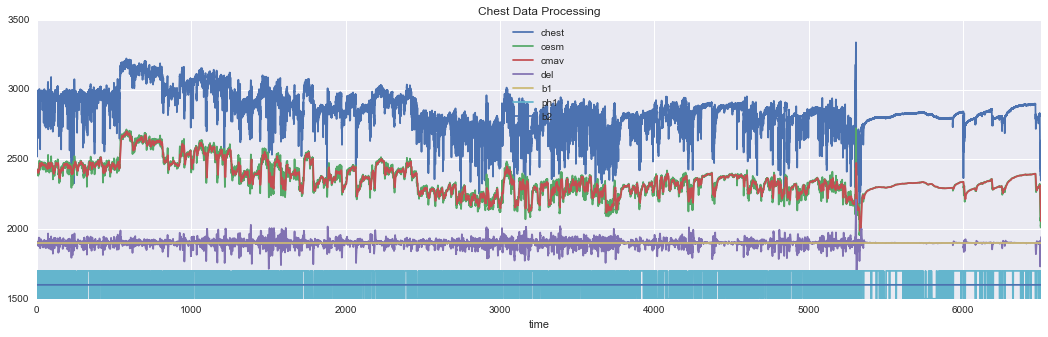

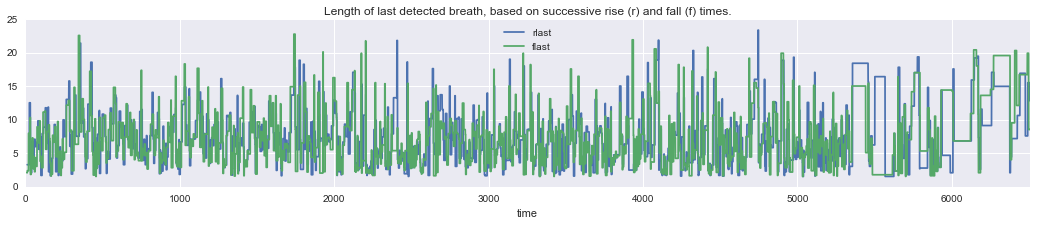

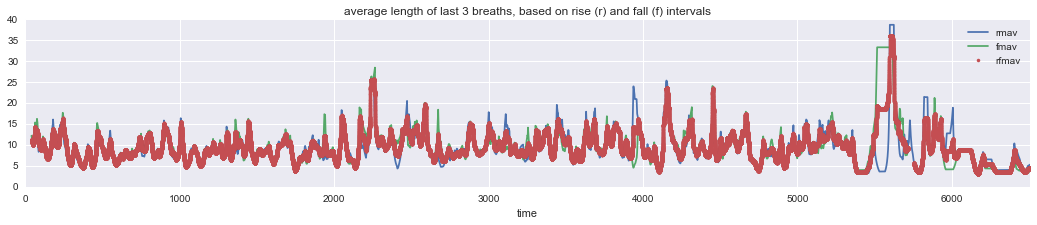

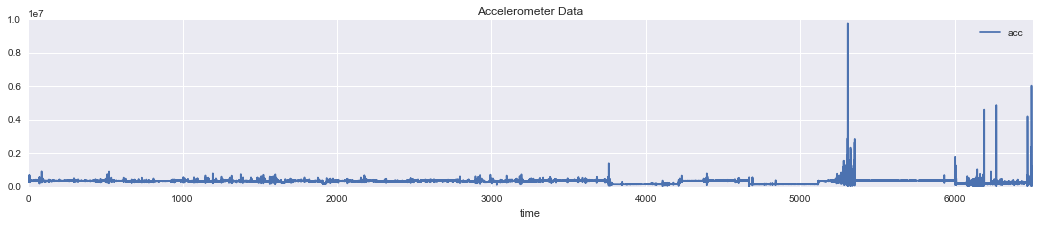

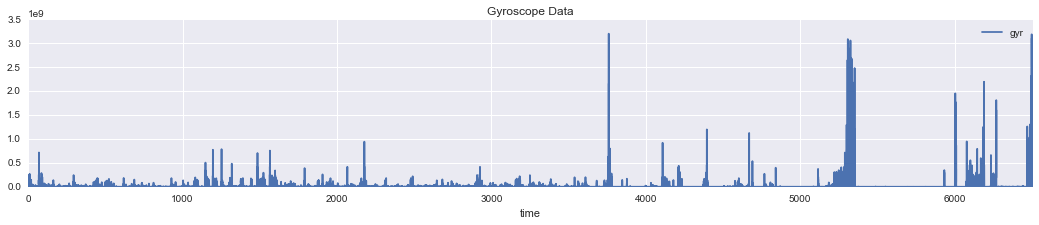

In [5]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 1600
g['b2'] = 1600
g.plot(x = 'time',y = ['chest','cesm','cmav','del','b1','ph1','b2'],figsize = (18,5),title = 'Chest Data Processing')
d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['-','-','.'], x = 'time',y = ['rmav','fmav','rfmav'], figsize = (18,3), title = 'average length of last 3 breaths, based on rise (r) and fall (f) intervals')
d.plot(x = 'time',y = 'acc',figsize = (18,3),title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3),title = 'Gyroscope Data')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [6]:
print(d[::1000]) # every thousandth line of the processed dataset

         index  chest  belly   ax   ay   az    gx     gy    gz    time  ...   \
0            0   2937   2490   28  543  272  1333   2422   782     0.0  ...    
1000      1000   2965   2622 -100  568  206  -359    993  -308    50.0  ...    
2000      2000   2958   2579   51  567  180   237   1318   583   100.0  ...    
3000      3000   2922   2571   32  575   96   744   2485   659   150.0  ...    
4000      4000   2929   2629    7  569  167   365    845   271   200.0  ...    
5000      5000   2982   2528  -32  555  212   318   1020   165   250.0  ...    
6000      6000   2839   2569   33  551  199   171   -290   -15   300.0  ...    
7000      7000   2960   2639   -4  566  172  1047     60   -74   350.0  ...    
8000      8000   2932   2642   28  568  155   425    781   330   400.0  ...    
9000      9000   2906   2593   -4  579  103   362  -6044 -1013   450.0  ...    
10000    10000   3040   2581    0  576  127     5   1838  -421   500.0  ...    
11000    11000   3191   2595  -60 -277  

In [7]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,fbtime,rlast,flast,rmav,fmav,rfmav,acc,gyr,b1,b2
0,0,2937,2490,28,543,272,1333,2422,782,0.00,...,[nan],NaN,NaN,NaN,NaN,NaN,369617,8254497,1900,1600
1,1,2941,2492,67,552,268,883,2652,596,0.05,...,[nan],NaN,NaN,NaN,NaN,NaN,381017,8168009,1900,1600
2,2,2950,2494,51,536,260,446,3531,407,0.10,...,[nan],NaN,NaN,NaN,NaN,NaN,357497,12832526,1900,1600
3,3,2954,2505,48,537,272,871,4831,744,0.15,...,[nan],NaN,NaN,NaN,NaN,NaN,364657,24650738,1900,1600
4,4,2964,2505,46,536,252,1146,5292,610,0.20,...,[nan],NaN,NaN,NaN,NaN,NaN,352916,29690680,1900,1600
5,5,2964,2503,15,553,243,1676,5608,569,0.25,...,[nan],NaN,NaN,NaN,NaN,NaN,365083,34582401,1900,1600
6,6,2969,2515,7,560,227,1906,5293,142,0.30,...,[nan],NaN,NaN,NaN,NaN,NaN,365178,31668849,1900,1600
7,7,2974,2518,35,574,207,1607,5577,-319,0.35,...,[nan],NaN,NaN,NaN,NaN,NaN,373550,33787139,1900,1600
8,8,2970,2510,30,591,207,862,5656,541,0.40,...,[nan],NaN,NaN,NaN,NaN,NaN,393030,33026061,1900,1600
9,9,2983,2507,15,561,217,516,5673,1426,0.45,...,[nan],NaN,NaN,NaN,NaN,NaN,362035,34482661,1900,1600
